In [231]:
# Data preproccesing and visualization
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt
import seaborn as sns
# Encoding , Imputing and Scaling
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OrdinalEncoder,LabelEncoder
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler
# Metrics and Pipeline
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score, f1_score, make_scorer, roc_auc_score, confusion_matrix,recall_score,precision_score
from sklearn.metrics import classification_report

# ML Models
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.tree import DecisionTreeClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier
# Neural Network
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader,TensorDataset
from tqdm import tqdm
from torchvision import transforms
import torch.optim as optim
from torchsummary import summary
from torch.utils.tensorboard import SummaryWriter
from datetime import datetime

## EDA

In [4]:
train_dataframe = pd.read_csv("train.csv", index_col="id")

In [183]:
test_dataframe = pd.read_csv("test.csv", index_col="id")

In [14]:
train_dataframe.head()

,class,cap-diameter,cap-shape,cap-surface,cap-color,does-bruise-or-bleed,gill-attachment,gill-spacing,gill-color,stem-height,...,stem-root,stem-surface,stem-color,veil-type,veil-color,has-ring,ring-type,spore-print-color,habitat,season
id,,,,,,,,,,,,,,,,,,,,,
0,e,8.80,f,s,u,f,a,c,w,4.51,...,NaN,NaN,w,NaN,NaN,f,f,NaN,d,a
1,p,4.51,x,h,o,f,a,c,n,4.79,...,NaN,y,o,NaN,NaN,t,z,NaN,d,w
2,e,6.94,f,s,b,f,x,c,w,6.85,...,NaN,s,n,NaN,NaN,f,f,NaN,l,w
3,e,3.88,f,y,g,f,s,NaN,g,4.16,...,NaN,NaN,w,NaN,NaN,f,f,NaN,d,u
4,e,5.85,x,l,w,f,d,NaN,w,3.37,...,NaN,NaN,w,NaN,NaN,f,f,NaN,g,a


In [48]:
train_dataframe.info()

<class 'pandas.core.frame.DataFrame'>
Index: 3116945 entries, 0 to 3116944
Data columns (total 21 columns):
 #   Column                Dtype  
---  ------                -----  
 0   class                 object 
 1   cap-diameter          float64
 2   cap-shape             object 
 3   cap-surface           object 
 4   cap-color             object 
 5   does-bruise-or-bleed  object 
 6   gill-attachment       object 
 7   gill-spacing          object 
 8   gill-color            object 
 9   stem-height           float64
 10  stem-width            float64
 11  stem-root             object 
 12  stem-surface          object 
 13  stem-color            object 
 14  veil-type             object 
 15  veil-color            object 
 16  has-ring              object 
 17  ring-type             object 
 18  spore-print-color     object 
 19  habitat               object 
 20  season                object 
dtypes: float64(3), object(18)
memory usage: 523.2+ MB


In [50]:
train_dataframe.describe()

,cap-diameter,stem-height,stem-width
count,3.116941e+06,3.116945e+06,3.116945e+06
mean,6.309848e+00,6.348333e+00,1.115379e+01
std,4.657931e+00,2.699755e+00,8.095477e+00
min,3.000000e-02,0.000000e+00,0.000000e+00
25%,3.320000e+00,4.670000e+00,4.970000e+00
50%,5.750000e+00,5.880000e+00,9.650000e+00
75%,8.240000e+00,7.410000e+00,1.563000e+01
max,8.067000e+01,8.872000e+01,1.029000e+02


In [14]:
print(f"The dataset has {len(train_dataframe)} rows and {len(train_dataframe.columns)} features")

The dataset has 3116945 rows and 21 features


In [16]:
missing_values = train_dataframe.isnull().sum()
missing_values_with_counts = missing_values[missing_values > 0]
print(f"{len(missing_values_with_counts)} columns have Missing Values")

17 columns have Missing Values


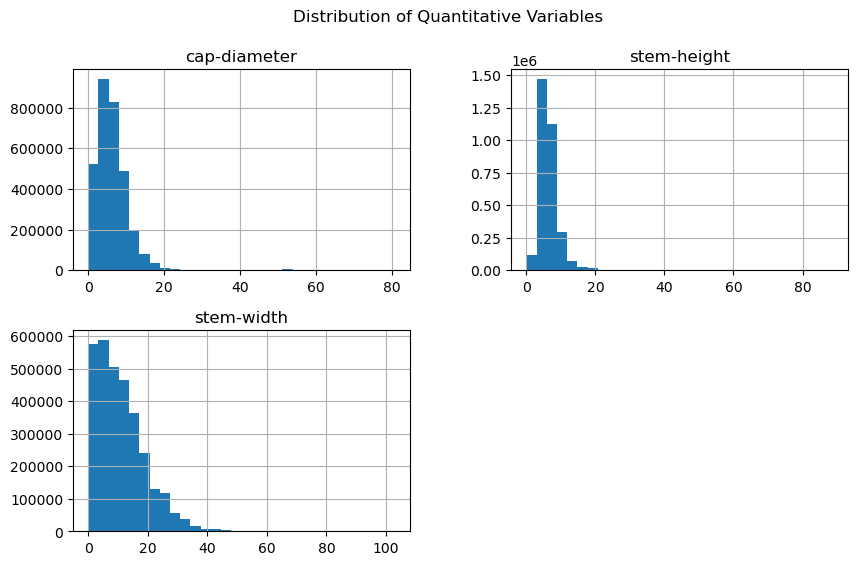

In [98]:
import matplotlib.pyplot as plt

train_dataframe[['cap-diameter', 'stem-height', 'stem-width']].hist(bins=30, figsize=(10, 6))
plt.suptitle('Distribution of Quantitative Variables')
plt.show()


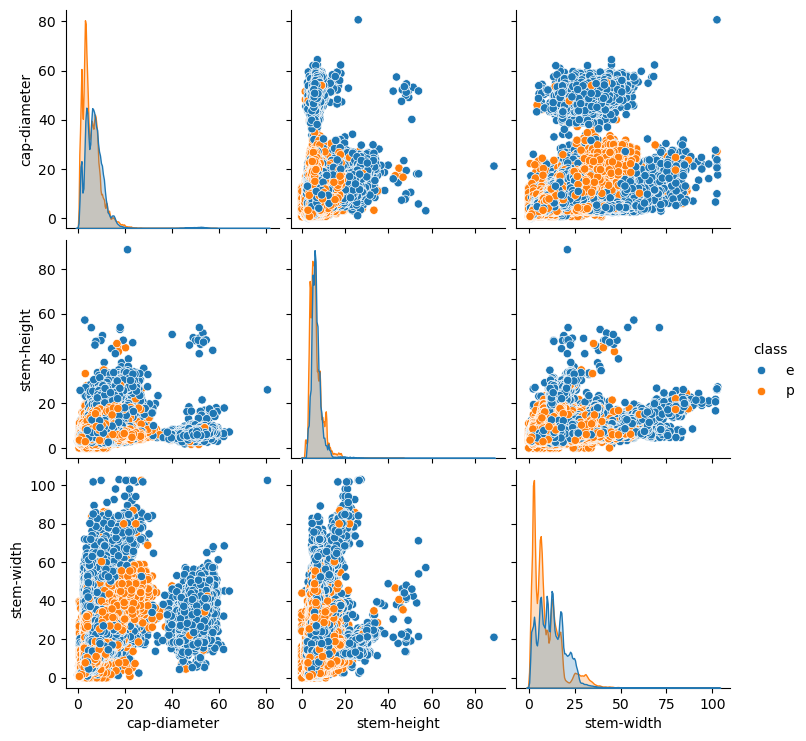

In [106]:
sns.pairplot(train_dataframe[['cap-diameter', 'stem-height', 'stem-width', 'class']], hue='class')
plt.show()

In [ ]:
plt.figure(figsize=(10, 6))
sns.heatmap(train_dataframe.isnull(), cbar=False, cmap='viridis')
plt.title('Missing Values')
plt.show()

## Handle Missing Values

In [9]:
numerical_missing_values = train_dataframe.select_dtypes(include=['float64']).isna().sum()
numerical_missing_values_with_counts = numerical_missing_values[numerical_missing_values > 0]
print("Missing values in numerical columns:")
print(numerical_missing_values_with_counts)

categorical_missing_values = train_dataframe.select_dtypes(include=['object', 'category']).isnull().sum()
categorical_missing_values_with_counts = categorical_missing_values[categorical_missing_values > 0]
print("\nMissing values in categorical columns:")
print(categorical_missing_values_with_counts)

Missing values in numerical columns:
cap-diameter    4
dtype: int64

Missing values in categorical columns:
cap-shape                    40
cap-surface              671023
cap-color                    12
does-bruise-or-bleed          8
gill-attachment          523936
gill-spacing            1258435
gill-color                   57
stem-root               2757023
stem-surface            1980861
stem-color                   38
veil-type               2957493
veil-color              2740947
has-ring                     24
ring-type                128880
spore-print-color       2849682
habitat                      45
dtype: int64


In [10]:
# Numerical data
numerical_missing_values_columns = numerical_missing_values_with_counts.index.to_list()
imputer_num = SimpleImputer(strategy='mean')
train_dataframe[numerical_missing_values_columns] = imputer_num.fit_transform(train_dataframe[numerical_missing_values_columns])
# Categorical data
categorical_missing_values_columns = categorical_missing_values_with_counts.index.to_list()
imputer_cat = SimpleImputer(strategy='most_frequent')
train_dataframe[categorical_missing_values_columns] = imputer_cat.fit_transform(train_dataframe[categorical_missing_values_columns])

## Transform Categorical Data

In [13]:
categorical_columns = train_dataframe.select_dtypes(include=['object', 'category']).columns.tolist()[1::] # Except a target ("class")
print(f"{len(categorical_columns)} categorical columns\n")
print(categorical_columns)

17 categorical columns

['cap-shape', 'cap-surface', 'cap-color', 'does-bruise-or-bleed', 'gill-attachment', 'gill-spacing', 'gill-color', 'stem-root', 'stem-surface', 'stem-color', 'veil-type', 'veil-color', 'has-ring', 'ring-type', 'spore-print-color', 'habitat', 'season']


In [14]:
ordinal_encoder = OrdinalEncoder()

train_dataframe[categorical_columns] = ordinal_encoder.fit_transform(train_dataframe[categorical_columns])

In [15]:
label_encoder = LabelEncoder()

train_dataframe["class"] = label_encoder.fit_transform(train_dataframe["class"])

In [65]:
train_dataframe.head()

,class,cap-diameter,cap-shape,cap-surface,cap-color,does-bruise-or-bleed,gill-attachment,gill-spacing,gill-color,stem-height,...,stem-root,stem-surface,stem-color,veil-type,veil-color,has-ring,ring-type,spore-print-color,habitat,season
id,,,,,,,,,,,,,,,,,,,,,
0,0,8.80,53.0,72.0,72.0,8.0,44.0,28.0,59.0,4.51,...,15.0,51.0,55.0,19.0,21.0,5.0,18.0,17.0,25.0,0.0
1,1,4.51,71.0,56.0,64.0,8.0,44.0,28.0,46.0,4.79,...,15.0,58.0,47.0,19.0,21.0,18.0,39.0,17.0,25.0,3.0
2,0,6.94,53.0,72.0,49.0,8.0,75.0,28.0,59.0,6.85,...,15.0,51.0,46.0,19.0,21.0,5.0,18.0,17.0,36.0,3.0
3,0,3.88,53.0,81.0,57.0,8.0,70.0,28.0,37.0,4.16,...,15.0,51.0,55.0,19.0,21.0,5.0,18.0,17.0,25.0,2.0
4,0,5.85,71.0,65.0,74.0,8.0,47.0,28.0,59.0,3.37,...,15.0,51.0,55.0,19.0,21.0,5.0,18.0,17.0,29.0,0.0


## EDA (after transforming data)

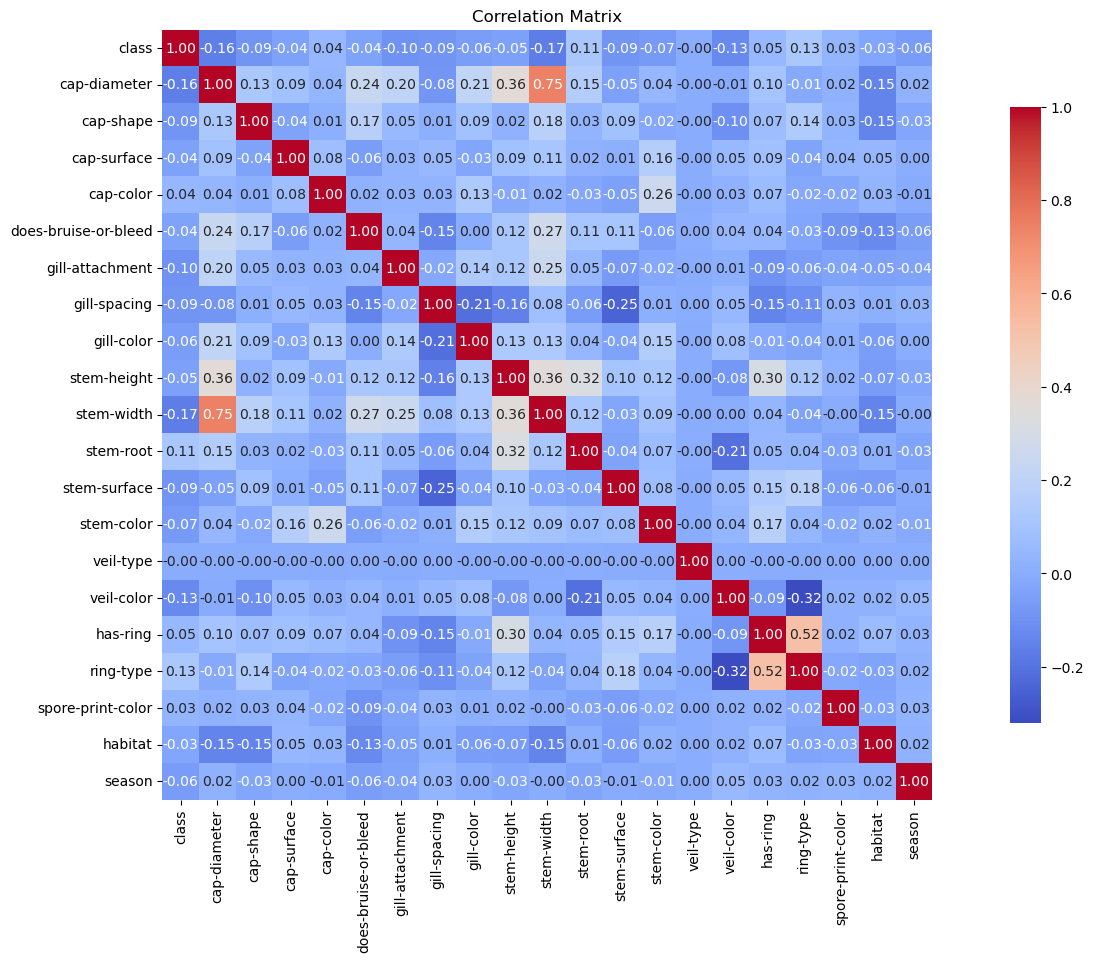

In [66]:
correlation_matrix = train_dataframe.corr()

plt.figure(figsize=(20, 10))

sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap='coolwarm', square=True, cbar_kws={"shrink": .8})
plt.title('Correlation Matrix')
plt.show()

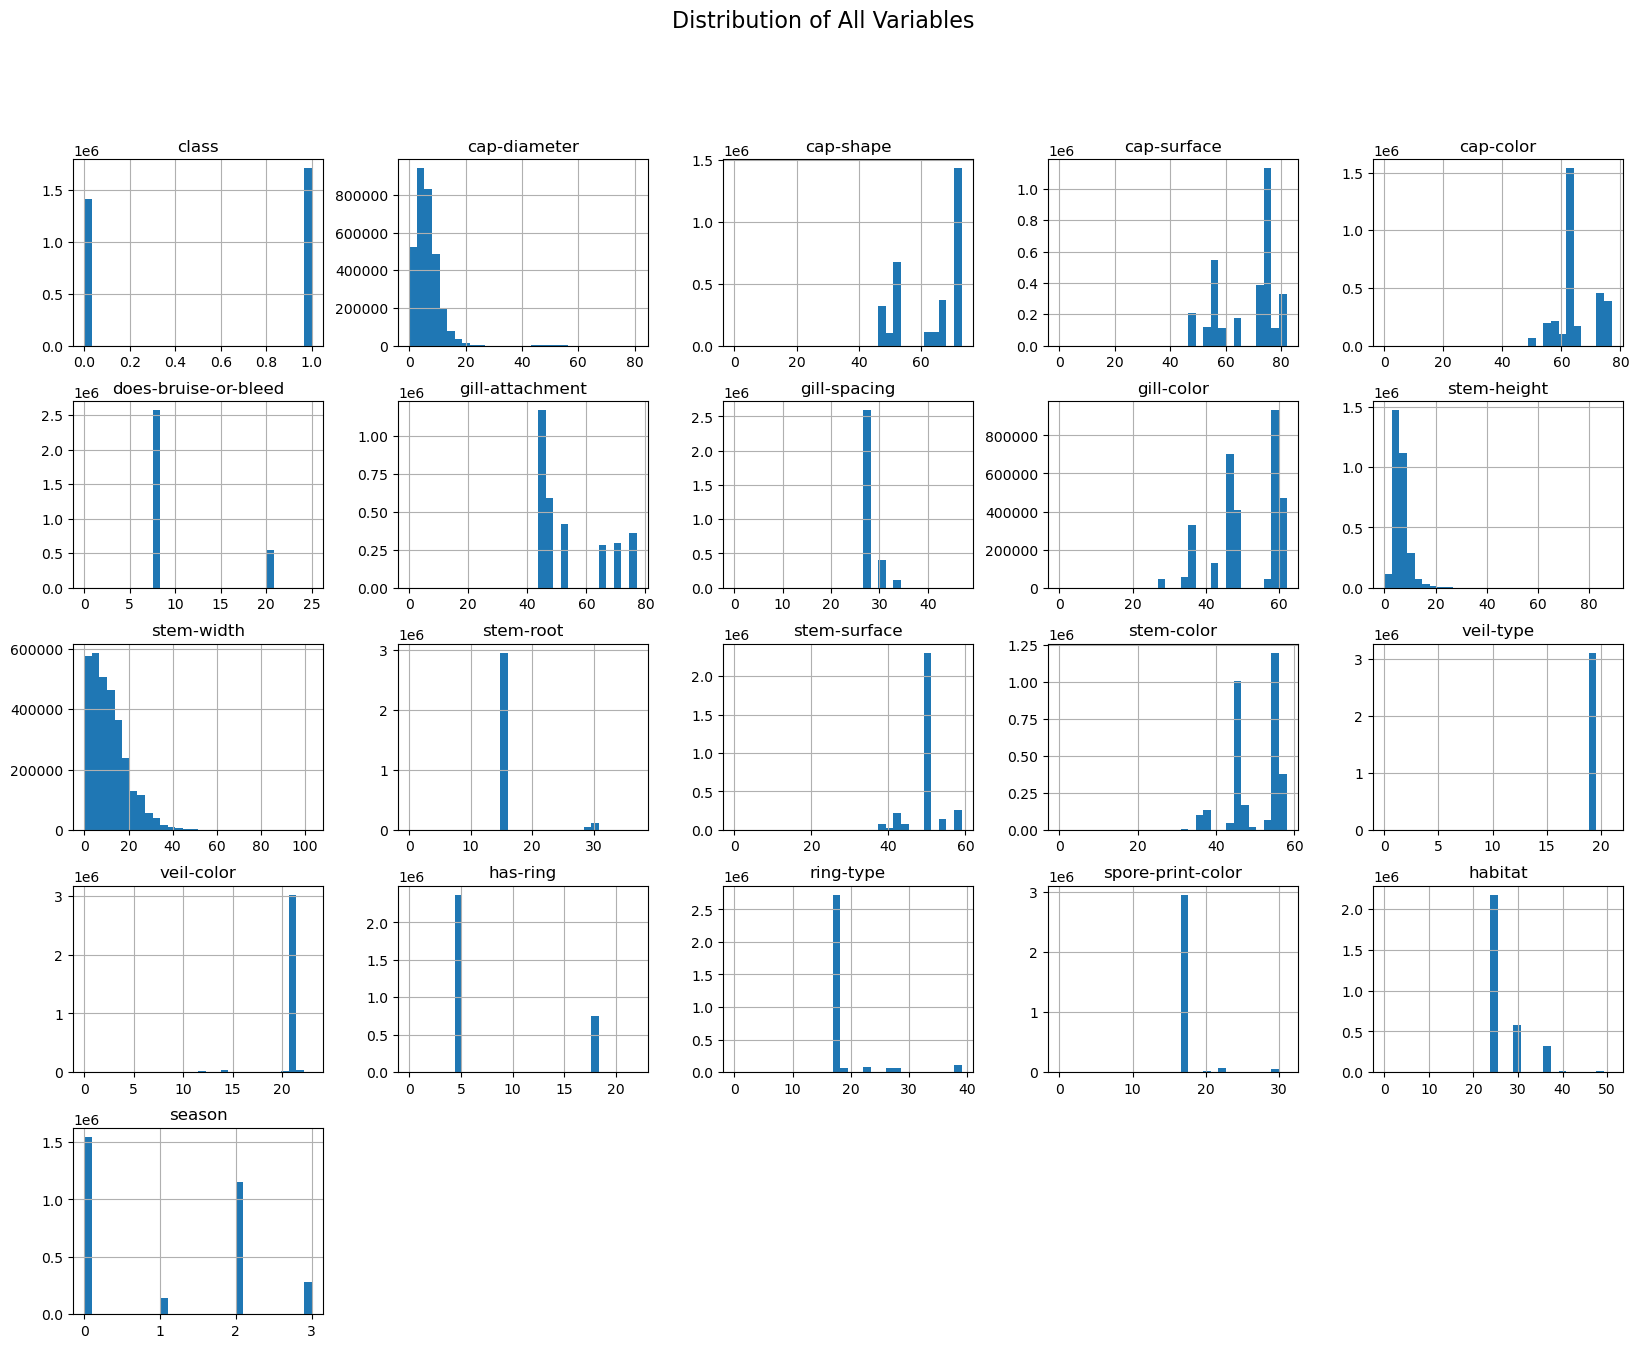

In [22]:
import matplotlib.pyplot as plt
import seaborn as sns

train_dataframe.hist(bins=30, figsize=(20, 15))
plt.suptitle('Distribution of All Variables', size=16)
plt.show()

## ML

In [30]:
X = train_dataframe.drop("class",axis=1)
y = train_dataframe["class"]

In [32]:
print(f"The shape of features {X.shape}")
print(f"The shape of target {y.shape}")

The shape of features (3116945, 20)
The shape of target (3116945,)


In [34]:
X_train , X_valid , y_train, y_valid  = train_test_split(X,y , test_size= 0.1,random_state=1337)

In [53]:
results = {}

### RandomForestClassifier

In [59]:
rfc = RandomForestClassifier()
param_grid = {
    "n_estimators" : [100, 150],
    "max_depth" : [None , 1 , 2 ,3 ]
}

GRID = GridSearchCV(estimator=rfc , param_grid=param_grid, cv=5)
GRID.fit(X_train , y_train)
y_pred = GRID.predict(X_valid)
print(GRID.best_estimator_)
print(GRID.best_score_)

accuracy = accuracy_score(y_valid, y_pred)


RandomForestClassifier(n_estimators=150)
0.9914364138668568


In [55]:
rfc_best = RandomForestClassifier(n_estimators=150, max_depth=None)
rfc_best.fit(X_train,y_train)

In [87]:
y_pred = rfc_best.predict(X_valid)
model_name = "RandomForest"
accuracy = accuracy_score(y_valid, y_pred)
roc_auc = roc_auc_score(y_valid, y_pred)
matrix = confusion_matrix(y_valid, y_pred)
f1 = f1_score(y_valid, y_pred)
precision = precision_score(y_valid, y_pred, average='weighted')  
recall = recall_score(y_valid, y_pred, average='weighted') 
classification = classification_report(y_valid, y_pred, output_dict=True)  

results[model_name] = {
    "Val Accuracy": accuracy,
    "Val Roc Auc": roc_auc,
    "Val F1 Score": f1,
    "Val Precision": precision,
    "Val Recall": recall,
    "Confusion Matrix": matrix.tolist(),  
    
}
data = {
    "Model": [],
    "Val Accuracy": [],
    "Val Roc Auc": [],
    "Val F1 Score": [],
    "Val Precision": [],
    "Val Recall": [],
    "Confusion Matrix": [],
    
}


for model_name, metrics in results.items():
    data["Model"].append(model_name)
    data["Val Accuracy"].append(metrics["Val Accuracy"])
    data["Val Roc Auc"].append(metrics["Val Roc Auc"])
    data["Val F1 Score"].append(metrics["Val F1 Score"])
    data["Val Precision"].append(metrics["Val Precision"])
    data["Val Recall"].append(metrics["Val Recall"])
    data["Confusion Matrix"].append(metrics["Confusion Matrix"])

results_df = pd.DataFrame(data)

### XGBClassifier

In [79]:
xgbc = XGBClassifier(use_label_encoder=False, eval_metric='logloss', device="cuda")

xgbc.fit(X_train,y_train)

/home/svyatoslav/anaconda3/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [19:24:04] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/home/svyatoslav/anaconda3/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [19:24:07] WARNING: /workspace/src/common/error_msg.cc:58: Falling back to prediction using DMatrix due to mismatched devices. This might lead to higher memory usage and slower performance. XGBoost is running on: cuda:0, while the input data is on: cpu.
Potential solutions:
- Use a data structure that matches the device ordinal in the booster.
- Set the device for booster before call to inplace_predict.

This warning will only be shown once.

  warnings.warn(smsg, UserWarning)


In [85]:
y_pred = xgbc.predict(X_valid)
model_name = "XGBClassifier"
accuracy = accuracy_score(y_valid, y_pred)
roc_auc = roc_auc_score(y_valid, y_pred)
matrix = confusion_matrix(y_valid, y_pred)
f1 = f1_score(y_valid, y_pred)
precision = precision_score(y_valid, y_pred, average='weighted')  
recall = recall_score(y_valid, y_pred, average='weighted') 
classification = classification_report(y_valid, y_pred, output_dict=True)  

results[model_name] = {
    "Val Accuracy": accuracy,
    "Val Roc Auc": roc_auc,
    "Val F1 Score": f1,
    "Val Precision": precision,
    "Val Recall": recall,
    "Confusion Matrix": matrix.tolist(),  
    
}
data = {
    "Model": [],
    "Val Accuracy": [],
    "Val Roc Auc": [],
    "Val F1 Score": [],
    "Val Precision": [],
    "Val Recall": [],
    "Confusion Matrix": [],
    
}


for model_name, metrics in results.items():
    data["Model"].append(model_name)
    data["Val Accuracy"].append(metrics["Val Accuracy"])
    data["Val Roc Auc"].append(metrics["Val Roc Auc"])
    data["Val F1 Score"].append(metrics["Val F1 Score"])
    data["Val Precision"].append(metrics["Val Precision"])
    data["Val Recall"].append(metrics["Val Recall"])
    data["Confusion Matrix"].append(metrics["Confusion Matrix"])

results_df = pd.DataFrame(data)

### CatBoostClassifier

In [ ]:
catboost = CatBoostClassifier()
catboost.fit(X_train,y_train)


In [91]:
y_pred = catboost.predict(X_valid)
model_name = "CatBoostClassifier"
accuracy = accuracy_score(y_valid, y_pred)
roc_auc = roc_auc_score(y_valid, y_pred)
matrix = confusion_matrix(y_valid, y_pred)
f1 = f1_score(y_valid, y_pred)
precision = precision_score(y_valid, y_pred, average='weighted')  
recall = recall_score(y_valid, y_pred, average='weighted') 
classification = classification_report(y_valid, y_pred, output_dict=True)  

results[model_name] = {
    "Val Accuracy": accuracy,
    "Val Roc Auc": roc_auc,
    "Val F1 Score": f1,
    "Val Precision": precision,
    "Val Recall": recall,
    "Confusion Matrix": matrix.tolist(),  
    
}
data = {
    "Model": [],
    "Val Accuracy": [],
    "Val Roc Auc": [],
    "Val F1 Score": [],
    "Val Precision": [],
    "Val Recall": [],
    "Confusion Matrix": [],
    
}


for model_name, metrics in results.items():
    data["Model"].append(model_name)
    data["Val Accuracy"].append(metrics["Val Accuracy"])
    data["Val Roc Auc"].append(metrics["Val Roc Auc"])
    data["Val F1 Score"].append(metrics["Val F1 Score"])
    data["Val Precision"].append(metrics["Val Precision"])
    data["Val Recall"].append(metrics["Val Recall"])
    data["Confusion Matrix"].append(metrics["Confusion Matrix"])

results_df = pd.DataFrame(data)

### LGBMClassifier

In [ ]:
lgbm = LGBMClassifier()
lgbm.fit(X_train,y_train)

In [99]:
y_pred = lgbm.predict(X_valid)
model_name = "LGBMClassifier"
accuracy = accuracy_score(y_valid, y_pred)
roc_auc = roc_auc_score(y_valid, y_pred)
matrix = confusion_matrix(y_valid, y_pred)
f1 = f1_score(y_valid, y_pred)
precision = precision_score(y_valid, y_pred, average='weighted')  
recall = recall_score(y_valid, y_pred, average='weighted') 
classification = classification_report(y_valid, y_pred, output_dict=True)  

results[model_name] = {
    "Val Accuracy": accuracy,
    "Val Roc Auc": roc_auc,
    "Val F1 Score": f1,
    "Val Precision": precision,
    "Val Recall": recall,
    "Confusion Matrix": matrix.tolist(),  
    
}
data = {
    "Model": [],
    "Val Accuracy": [],
    "Val Roc Auc": [],
    "Val F1 Score": [],
    "Val Precision": [],
    "Val Recall": [],
    "Confusion Matrix": [],
    
}


for model_name, metrics in results.items():
    data["Model"].append(model_name)
    data["Val Accuracy"].append(metrics["Val Accuracy"])
    data["Val Roc Auc"].append(metrics["Val Roc Auc"])
    data["Val F1 Score"].append(metrics["Val F1 Score"])
    data["Val Precision"].append(metrics["Val Precision"])
    data["Val Recall"].append(metrics["Val Recall"])
    data["Confusion Matrix"].append(metrics["Confusion Matrix"])

results_df = pd.DataFrame(data)

### DecisionTreeClassifier

In [103]:
dtc = DecisionTreeClassifier()

dtc.fit(X_train, y_train)

DecisionTreeClassifier()

In [105]:
y_pred = dtc.predict(X_valid)
model_name = "DecisionTreeClassifier"
accuracy = accuracy_score(y_valid, y_pred)
roc_auc = roc_auc_score(y_valid, y_pred)
matrix = confusion_matrix(y_valid, y_pred)
f1 = f1_score(y_valid, y_pred)
precision = precision_score(y_valid, y_pred, average='weighted')  
recall = recall_score(y_valid, y_pred, average='weighted') 
classification = classification_report(y_valid, y_pred, output_dict=True)  

results[model_name] = {
    "Val Accuracy": accuracy,
    "Val Roc Auc": roc_auc,
    "Val F1 Score": f1,
    "Val Precision": precision,
    "Val Recall": recall,
    "Confusion Matrix": matrix.tolist(),  
    
}
data = {
    "Model": [],
    "Val Accuracy": [],
    "Val Roc Auc": [],
    "Val F1 Score": [],
    "Val Precision": [],
    "Val Recall": [],
    "Confusion Matrix": [],
    
}


for model_name, metrics in results.items():
    data["Model"].append(model_name)
    data["Val Accuracy"].append(metrics["Val Accuracy"])
    data["Val Roc Auc"].append(metrics["Val Roc Auc"])
    data["Val F1 Score"].append(metrics["Val F1 Score"])
    data["Val Precision"].append(metrics["Val Precision"])
    data["Val Recall"].append(metrics["Val Recall"])
    data["Confusion Matrix"].append(metrics["Confusion Matrix"])

results_df = pd.DataFrame(data)

In [119]:
results_df['Mean'] = results_df[['Val Accuracy', 'Val Roc Auc', 'Val F1 Score', 'Val Precision', 'Val Recall']].mean(axis=1)

results_df = results_df.sort_values(by='Mean', ascending=False)

results_df

,Model,Val Accuracy,Val Roc Auc,Val F1 Score,Val Precision,Val Recall,Confusion Matrix,Mean
0,RandomForest,0.991636,0.991674,0.992354,0.991641,0.991636,"[[139916, 1118], [1489, 169172]]",0.991788
2,CatBoostClassifier,0.990616,0.990667,0.991419,0.990622,0.990616,"[[139794, 1240], [1685, 168976]]",0.990788
1,XGBClassifier,0.990183,0.990268,0.991020,0.990193,0.990183,"[[139788, 1246], [1814, 168847]]",0.990369
3,LGBMClassifier,0.987100,0.987206,0.988194,0.987116,0.987100,"[[139388, 1646], [2375, 168286]]",0.987343
4,DecisionTreeClassifier,0.982284,0.982137,0.983820,0.982285,0.982284,"[[138296, 2738], [2784, 167877]]",0.982562


### Neural Network

In [121]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

#### Prepare Dataset for NN

In [123]:
class Poisonous_Mushrooms_Dataset(Dataset):
    def __init__(self, X, y):
        self.X = torch.tensor(X.values, dtype=torch.float32)
        self.y = torch.tensor(y.values, dtype=torch.float32)

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]
        

In [125]:
train_dataset = Poisonous_Mushrooms_Dataset(
    X_train,
    y_train,
)
valid_dataset = Poisonous_Mushrooms_Dataset(
    X_valid,
    y_valid,
)

train_loader = DataLoader(train_dataset, batch_size=32,shuffle=True)
valid_loader = DataLoader(valid_dataset,batch_size=32,shuffle=False)


In [127]:
x,y = next(iter(train_loader))
x.shape , y.shape

(torch.Size([32, 20]), torch.Size([32]))

#### Model Architecture

In [130]:
class Neural_Network(nn.Module):
    def __init__(self, input_dim):
        super(Neural_Network, self).__init__()
        self.fc1 = nn.Linear(input_dim, 512)
        self.fc2 = nn.Linear(512,512)
        self.fc3 = nn.Linear(512, 256)  
        self.fc4 = nn.Linear(256, 128)
        self.fc5 = nn.Linear(128, 1)
        self.relu = nn.ReLU()                    
        self.sigmoid = nn.Sigmoid()             

    def forward(self, x):
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)
        x = self.relu(x)
        x = self.fc3(x)
        x = self.relu(x)
        x = self.fc4(x)
        x = self.relu(x)
        x = self.fc5(x)
        x = self.sigmoid(x) 
        return x

In [132]:
input_dimension = X_train.shape[1]
model = Neural_Network(input_dimension).to(device)
optimizer = optim.Adam(model.parameters(),lr=0.001)
loss_function = nn.BCELoss()

In [134]:
print(summary(model ,(32,20)))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1              [-1, 32, 512]          10,752
              ReLU-2              [-1, 32, 512]               0
            Linear-3              [-1, 32, 512]         262,656
              ReLU-4              [-1, 32, 512]               0
            Linear-5              [-1, 32, 256]         131,328
              ReLU-6              [-1, 32, 256]               0
            Linear-7              [-1, 32, 128]          32,896
              ReLU-8              [-1, 32, 128]               0
            Linear-9                [-1, 32, 1]             129
          Sigmoid-10                [-1, 32, 1]               0
Total params: 437,761
Trainable params: 437,761
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.69
Params size (MB): 1.67
Estimated T

#### Train Model

In [136]:
def train_one_epoch(epoch_index, tb_writer):
    running_loss = 0
    last_loss = 0
    
    correct_predictions = 0
    total_predictions = 0
    
    for i, data in enumerate(train_loader):
        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()

        outputs = model(inputs)
        # print(outputs.shape)
        loss = loss_function(outputs,labels.reshape(-1,1))
        loss.backward()

        optimizer.step()

        running_loss += loss.item()

        predictions = (outputs > 0.5).float()

        correct_predictions += (predictions == labels.reshape(-1,1)).sum().item()
        total_predictions += labels.size(0)
        
        if i % 1000 == 999:
            last_loss = running_loss / 1000 
            accuracy = correct_predictions / total_predictions  
            
            print(f'  batch {i + 1} loss: {last_loss}, accuracy: {accuracy:.4f}')
            
            tb_x = epoch_index * len(train_loader) + i + 1
            tb_writer.add_scalar('Loss/train', last_loss, tb_x)
            tb_writer.add_scalar('Accuracy/train', accuracy, tb_x)
            
            running_loss = 0.
            correct_predictions = 0
            total_predictions = 0
    return  last_loss



In [138]:
import os

timestamp = datetime.now().strftime('%Y%m%d_%H%M%S')
writer = SummaryWriter('runs/fashion_trainer_{}'.format(timestamp))
epoch_number = 0


save_dir = 'saved_models'
if not os.path.exists(save_dir):
    os.makedirs(save_dir)


model_path = os.path.join(save_dir, "model_weights_{}.pth".format(timestamp))

EPOCHS = 2

best_vloss = 1_000_000.

for epoch in range(EPOCHS):
    print('EPOCH {}:'.format(epoch + 1))

    model.train(True).to(device)
    avg_loss = train_one_epoch(epoch + 1, writer)

    running_val_loss = 0.0
    correct_val_predictions = 0
    total_val_predictions = 0

    y_true = []
    y_pred = []

    model.eval().to(device)
    with torch.no_grad():
        for i, vdata in enumerate(valid_loader):
            vinputs, vlabels = vdata
            vinputs, vlabels = vinputs.to(device), vlabels.to(device)

            voutputs = model(vinputs).to(device)
            vloss = loss_function(voutputs, vlabels.reshape(-1, 1))
            running_val_loss += vloss.item()

            vpredictions = (voutputs > 0.5).float()  
            correct_val_predictions += (vpredictions == vlabels.reshape(-1, 1)).sum().item()
            total_val_predictions += vlabels.size(0)
            
            y_true.extend(vlabels.cpu().numpy().tolist())
            y_pred.extend(vpredictions.cpu().numpy().tolist())

    avg_vloss = running_val_loss / (i + 1)
    val_accuracy = correct_val_predictions / total_val_predictions  

    
    val_roc_auc = roc_auc_score(y_true, y_pred)
    val_f1 = f1_score(y_true, y_pred)
    val_precision = precision_score(y_true, y_pred)
    val_recall = recall_score(y_true, y_pred)
    val_conf_matrix = confusion_matrix(y_true, y_pred).tolist()  
    val_classification_report = classification_report(y_true, y_pred, output_dict=True)  

    print(f'LOSS train {avg_loss}, valid {avg_vloss}, Accuracy valid {val_accuracy}')
    
    
    writer.add_scalars('Training vs. Validation Loss',
                       {'Training': avg_loss, 'Validation': avg_vloss},
                       epoch + 1)
    writer.add_scalar('Validation Accuracy', val_accuracy, epoch + 1)
    writer.flush()

    
    results[epoch + 1] = {
        "Val Accuracy": val_accuracy,
        "Val Roc Auc": val_roc_auc,
        "Val F1 Score": val_f1,
        "Val Precision": val_precision,
        "Val Recall": val_recall,
        "Confusion Matrix": val_conf_matrix,
        "Classification Report": val_classification_report
    }
    
    
    torch.save(model.state_dict(), model_path)
    print(f'Model saved to {model_path}')


EPOCH 1:
  batch 1000 loss: 0.547807246491313, accuracy: 0.7003
  batch 2000 loss: 0.2754439162686467, accuracy: 0.8850
  batch 3000 loss: 0.18782998711429535, accuracy: 0.9323
  batch 4000 loss: 0.1590588331129402, accuracy: 0.9434
  batch 5000 loss: 0.15266553243901582, accuracy: 0.9475
  batch 6000 loss: 0.14125937678292394, accuracy: 0.9545
  batch 7000 loss: 0.12612928147707134, accuracy: 0.9580
  batch 8000 loss: 0.12462551880441607, accuracy: 0.9605
  batch 9000 loss: 0.12039366110693664, accuracy: 0.9614
  batch 10000 loss: 0.11866491492185742, accuracy: 0.9604
  batch 11000 loss: 0.12221951992623507, accuracy: 0.9631
  batch 12000 loss: 0.10928255965095013, accuracy: 0.9656
  batch 13000 loss: 0.1068786711380817, accuracy: 0.9677
  batch 14000 loss: 0.10999165355972945, accuracy: 0.9668
  batch 15000 loss: 0.10633829206228257, accuracy: 0.9675
  batch 16000 loss: 0.10650066674780101, accuracy: 0.9675
  batch 17000 loss: 0.09853961286367849, accuracy: 0.9702
  batch 18000 loss:

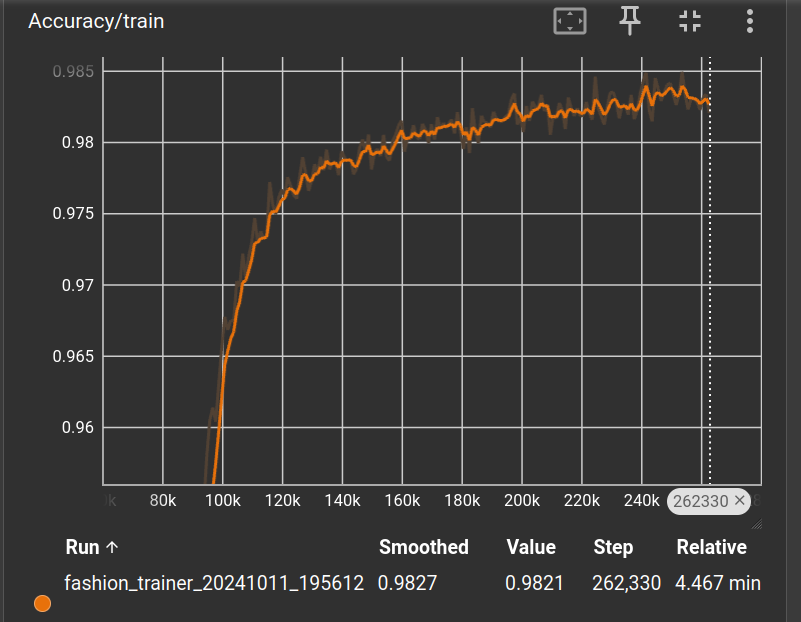

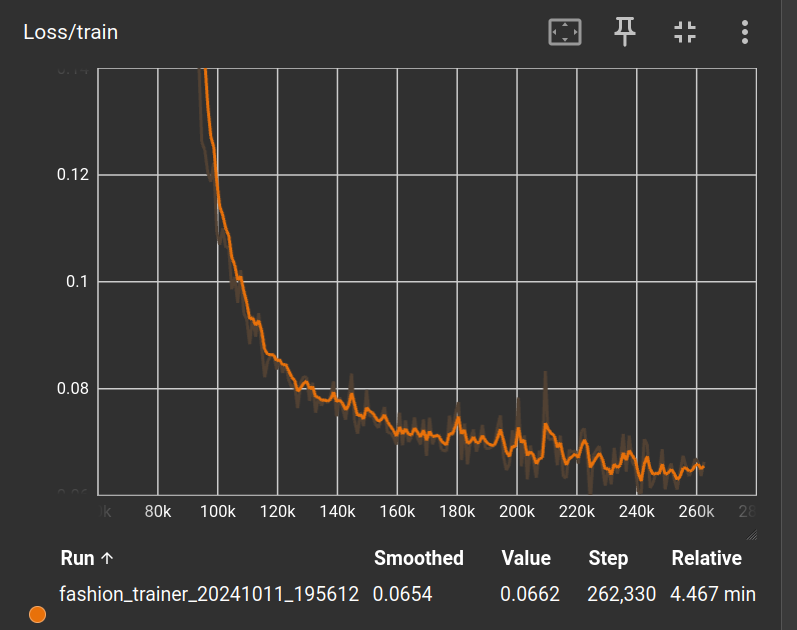

In [154]:
results_df['Mean'] = results_df[['Val Accuracy', 'Val Roc Auc', 'Val F1 Score', 'Val Precision', 'Val Recall']].mean(axis=1)

results_df = results_df.sort_values(by='Mean', ascending=False)

results_df

,Model,Val Accuracy,Val Roc Auc,Val F1 Score,Val Precision,Val Recall,Confusion Matrix,Mean
0,RandomForest,0.991636,0.991674,0.992354,0.991641,0.991636,"[[139916, 1118], [1489, 169172]]",0.991788
2,CatBoostClassifier,0.990616,0.990667,0.991419,0.990622,0.990616,"[[139794, 1240], [1685, 168976]]",0.990788
1,XGBClassifier,0.990183,0.990268,0.991020,0.990193,0.990183,"[[139788, 1246], [1814, 168847]]",0.990369
3,LGBMClassifier,0.987100,0.987206,0.988194,0.987116,0.987100,"[[139388, 1646], [2375, 168286]]",0.987343
6,2,0.984963,0.984706,0.986284,0.985162,0.987408,"[[138496, 2538], [2149, 168512]]",0.985705
4,DecisionTreeClassifier,0.982284,0.982137,0.983820,0.982285,0.982284,"[[138296, 2738], [2784, 167877]]",0.982562
5,1,0.973769,0.972820,0.976207,0.969694,0.982808,"[[135792, 5242], [2934, 167727]]",0.975060
